# Badge Holder Tests

The purpose of these tests was to determine if badges in antistatic / non-antistatic holders behave differently.
Our initial hypothesis is that the antistatic holders were obstructing the bluetooth signal due to the slight conductivitiy of antistatic surfaces. Therefore we expect to see more issues with the antistatic holders' RSSIs than of those in regular holders.

Expected issues include:
    -large variance when readings are taken at a constant distance
    -lower signal strength (higher RSSI), leading to less accurate range calculations.
Ideally, there would be no great difference between holder types, because then either one could be used without affecting data collection.

We will also be watching out for variation between individual badges. Each of these badges came from the same "batch," so we expect that they will have increased precision.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
holders_anti = ["EE:B4:AF:3F:05:80", # Badge 262
                "FF:0C:74:ED:C4:CD", # Badge 263
                "EC:FB:84:DE:35:4A", # Badge 264
                "C5:85:B9:18:8D:C3", # Badge 265
                "CB:5C:4B:7C:43:81", # Badge 266
                "E1:07:CE:CE:52:BE"] # Badge 267

In [3]:
holders_noanti = ["F1:4E:55:EA:ED:A4", # Badge 210
                  "E8:FA:0D:3C:01:82", # Badge 211
                  "C2:57:36:E6:71:6E", # Badge 212
                  "D9:86:6F:AF:E8:90", # Badge 213
                  "C1:96:24:5B:EB:97", # Badge 214
                  "C8:2F:80:DA:26:94"] # Badge 215

# Prepping the Data

In [4]:

# loads all of the distances' test data for both holder types
# @return - df_all - a PANDAS DataFrame of all the test data
def load_all():
    
    # @param - antistatic - boolean indicating whether to load antistatic or regular holders
    # @return - df_holders - a PANDAS DataFrame of all distances' test data for the specified holder type
    def load_holders(antistatic):
        as_str = "antistatic" if antistatic else "noantistatic"
        holders = holders_anti if antistatic else holders_noanti

        # @param - dist - int indicating the distance between the receiver and transmitter during the test
        def load_dist(dist):
            raw = pd.read_csv('logs_' + as_str + '/BLE_range_test_' + str(dist) + 'ft_' + as_str + '_CSV/000.csv')
            raw = raw.loc[(raw['RSSI']>-70)]              # RSSI values below about -70 are too weak to be significant
            df_dist = raw.loc[raw['MAC'].isin(holders)]   # filter by holder type
            return df_dist

        distances = [2, 4, 6, 8, 10]
        df_holders = pd.concat([load_dist(d) for d in distances], keys=distances, names=["FT"])
        return df_holders
    
    df_anti = load_holders(antistatic=True)
    df_noanti = load_holders(antistatic=False)
    df_all = pd.concat([df_anti, df_noanti], keys=["antistatic", "regular"], names=["HOLDER"])
    return df_all

In [5]:
data = load_all()

# Raw Data

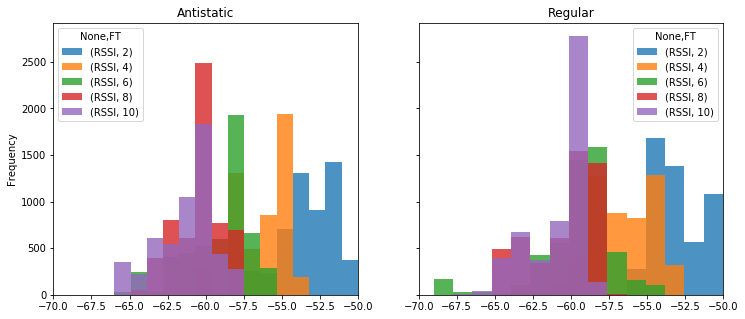

In [6]:
raw_data_0 = data.loc["antistatic"].drop(columns=["DATETIME", "MAC"]).unstack(level="FT")
raw_data_1 = data.loc["regular"].drop(columns=["DATETIME", "MAC"]).unstack(level="FT")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)
raw_data_0.plot(ax=axes[0], kind="hist", alpha=.8, bins=15, xlim=(-70,-50), title="Antistatic")
raw_data_1.plot(ax=axes[1], kind="hist", alpha=.8, bins=15, xlim=(-70,-50), title="Regular")

Here are some plots of the raw tests data, filtered by MAC address so that only those involved in the test are shown.
RSSI is plotted by count at each of the 5 distances used in the test. The peaks in the "Antistatic" plot seem to line up more clearly than in the "Regular" plot, but there isn't much else to say about these plots since the RSSI values here are based on a single sample, which is not how it's done on the badge. If anything, it is clear from these plots that some processing of the RSSI values needs to be done in order to get a reasonable range estimate.

# Rolling Mean

The rolling mean uses a window of 5 to generate samples, each of which are then averaged. This is similar to the actual mechanism used by the badge to collect RSSI data, in which a sample of 5 is collected and averaged before being stored. The roll is done per badge, so as to better simulate this system. Therefore these results should be more indicative of the actual badges' accuracy.

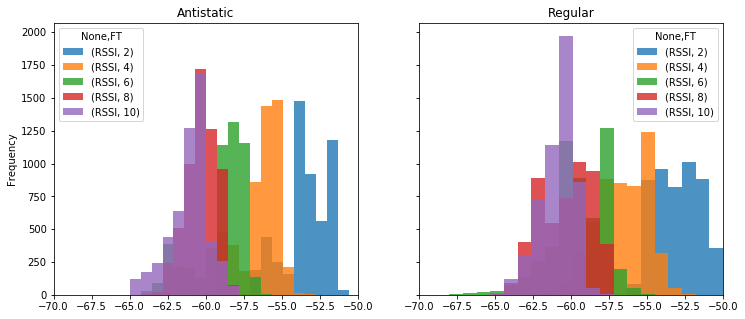

In [9]:
roll_mean0 = data.loc["antistatic"].groupby("MAC").rolling(5).mean().drop(columns=["MAC", "DATETIME"]).unstack(level="FT")
roll_mean1 = data.loc["regular"].groupby("MAC").rolling(5).mean().drop(columns=["MAC", "DATETIME"]).unstack(level="FT")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)
roll_mean0.plot(ax=axes[0], kind='hist', bins=20, alpha=.8, xlim=(-70,-50), title="Antistatic")
roll_mean1.plot(ax=axes[1], kind='hist', bins=20, alpha=.8, xlim=(-70,-50), title="Regular")

# Rolling Max

Likewise with the rolling mean, the rolling max uses a window of 5, of which the maximum is taken. This method seemed to be promising as a way of pre-processing the data during a previous test, so it is re-analyzed here. If this method proves to be better than rolling mean, it would be very easy to implement this change to improve the accuracy of RSSI ranging.

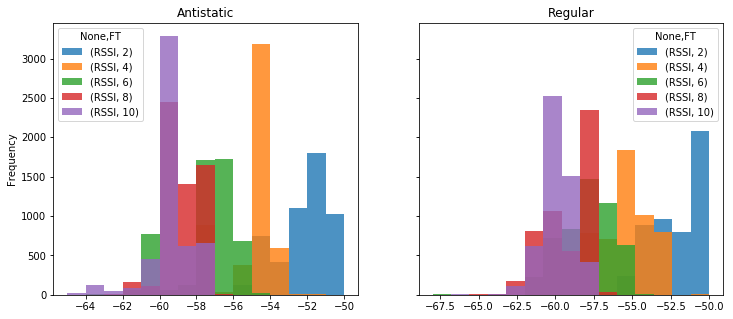

In [8]:
roll_max0 = data.loc["antistatic"].groupby("MAC").rolling(5).max().drop(columns=["MAC", "DATETIME"]).unstack(level="FT")
roll_max1 = data.loc["regular"].groupby("MAC").rolling(5).max().drop(columns=["MAC", "DATETIME"]).unstack(level="FT")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)
roll_max0.plot(ax=axes[0], kind='hist', bins=15, alpha=.8, xlim=(-70,-50), title="Antistatic")
roll_max1.plot(ax=axes[1], kind='hist', bins=15, alpha=.8, xlim=(-70,-50), title="Regular")

# Individual badges

## Antistatic Holders

### Rolling Mean

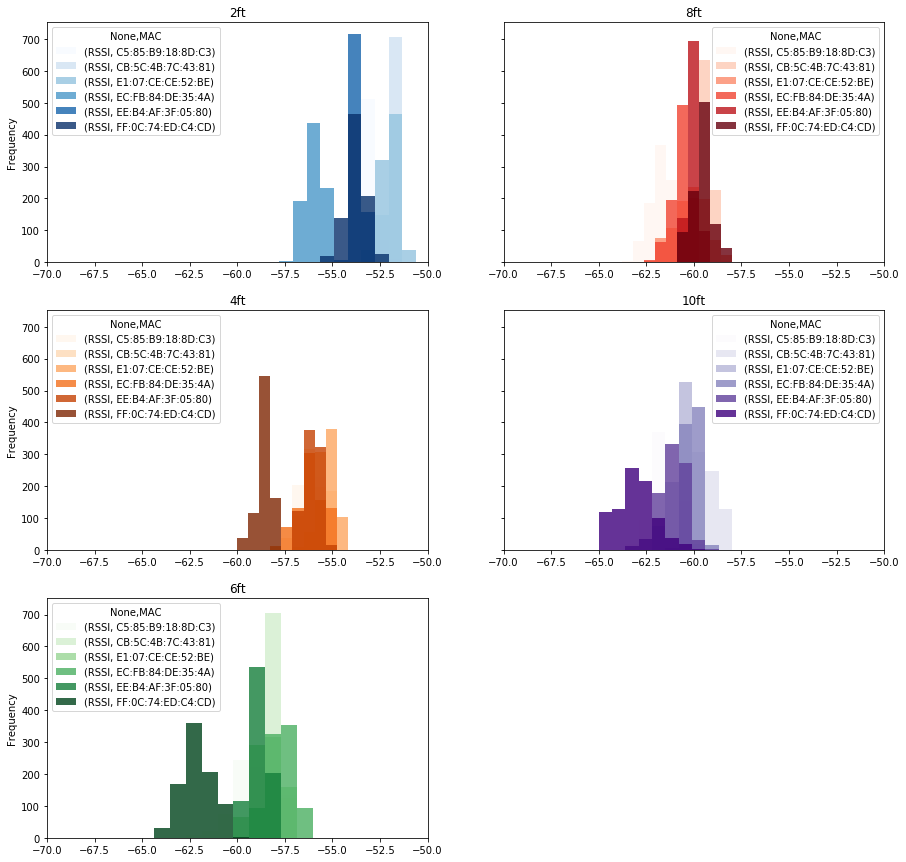

In [9]:
rmn2 = data.loc["antistatic"].loc[2].groupby("MAC").rolling(5).mean().unstack(level="MAC")
rmn4 = data.loc["antistatic"].loc[4].groupby("MAC").rolling(5).mean().unstack(level="MAC")
rmn6 = data.loc["antistatic"].loc[6].groupby("MAC").rolling(5).mean().unstack(level="MAC")
rmn8 = data.loc["antistatic"].loc[8].groupby("MAC").rolling(5).mean().unstack(level="MAC")
rmn10 = data.loc["antistatic"].loc[10].groupby("MAC").rolling(5).mean().unstack(level="MAC")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15), sharey=True)
rmn2.plot(ax=axes[0][0], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Blues", title="2ft")
rmn4.plot(ax=axes[1][0], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Oranges", title="4ft")
rmn6.plot(ax=axes[2][0], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Greens", title="6ft")
rmn8.plot(ax=axes[0][1], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Reds", title="8ft")
rmn10.plot(ax=axes[1][1], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Purples", title="10ft")
fig.delaxes(axes[2][1])

### Rolling Max

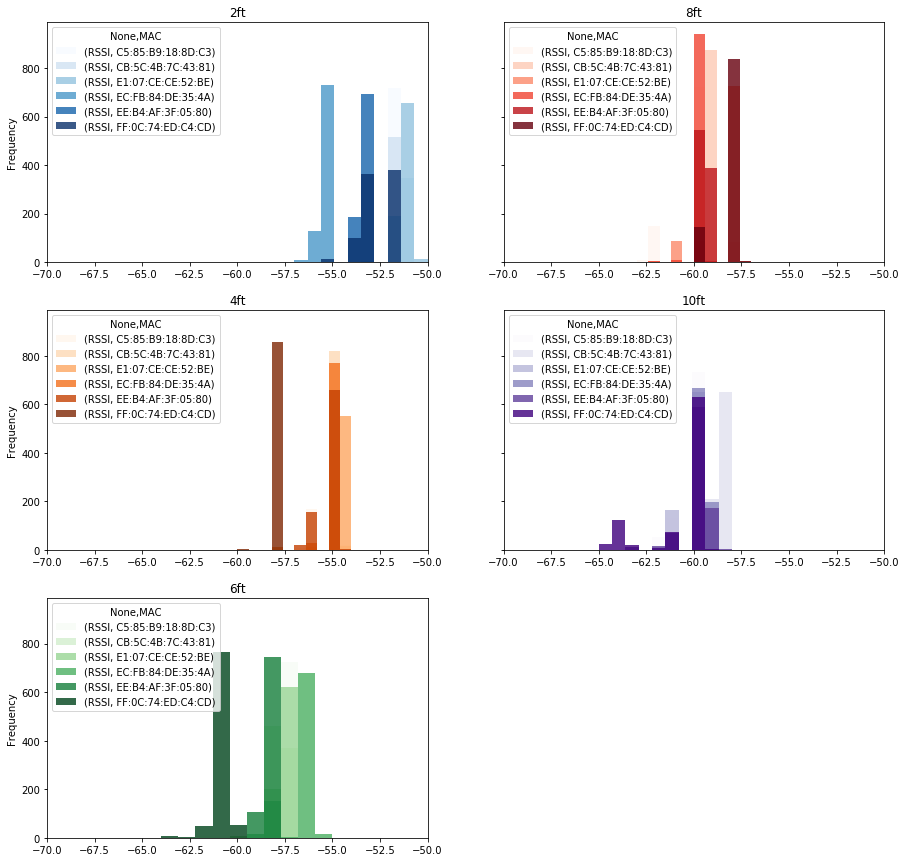

In [10]:
rmx2 = data.loc["antistatic"].loc[2].groupby("MAC").rolling(5).max().unstack(level="MAC")
rmx4 = data.loc["antistatic"].loc[4].groupby("MAC").rolling(5).max().unstack(level="MAC")
rmx6 = data.loc["antistatic"].loc[6].groupby("MAC").rolling(5).max().unstack(level="MAC")
rmx8 = data.loc["antistatic"].loc[8].groupby("MAC").rolling(5).max().unstack(level="MAC")
rmx10 = data.loc["antistatic"].loc[10].groupby("MAC").rolling(5).max().unstack(level="MAC")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15), sharey=True)
rmx2.plot(ax=axes[0][0], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Blues", title="2ft")
rmx4.plot(ax=axes[1][0], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Oranges", title="4ft")
rmx6.plot(ax=axes[2][0], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Greens", title="6ft")
rmx8.plot(ax=axes[0][1], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Reds", title="8ft")
rmx10.plot(ax=axes[1][1], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Purples", title="10ft")
fig.delaxes(axes[2][1])

## Regular Holders

### Rolling Mean

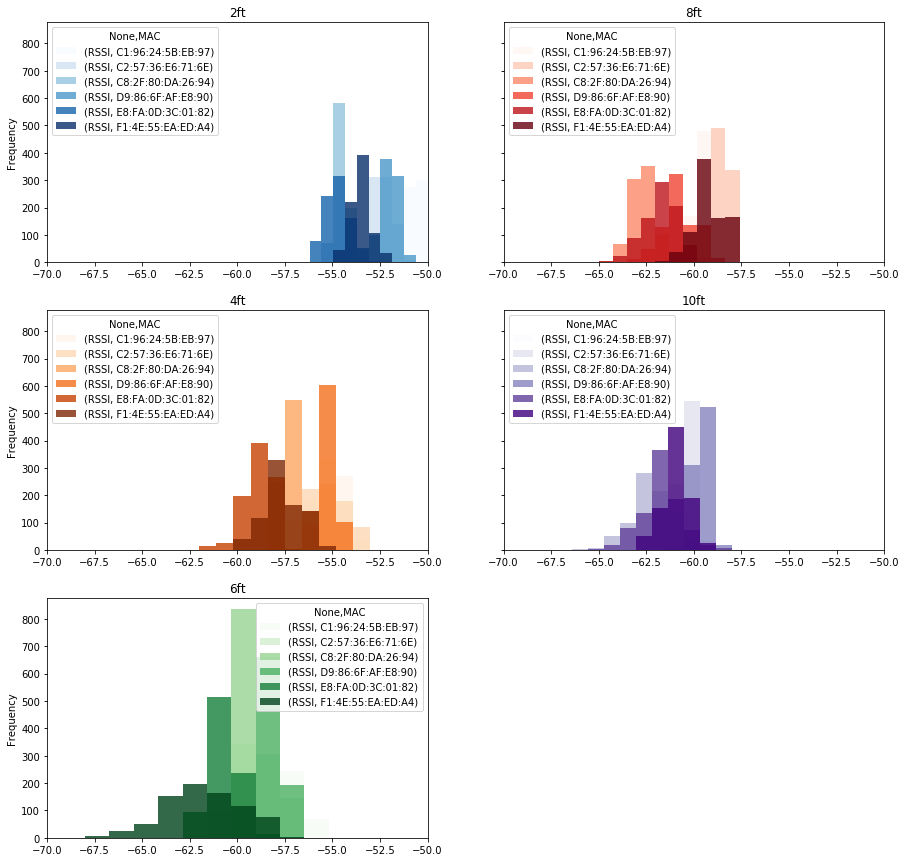

In [11]:
rmn2 = data.loc["regular"].loc[2].groupby("MAC").rolling(5).mean().unstack(level="MAC")
rmn4 = data.loc["regular"].loc[4].groupby("MAC").rolling(5).mean().unstack(level="MAC")
rmn6 = data.loc["regular"].loc[6].groupby("MAC").rolling(5).mean().unstack(level="MAC")
rmn8 = data.loc["regular"].loc[8].groupby("MAC").rolling(5).mean().unstack(level="MAC")
rmn10 = data.loc["regular"].loc[10].groupby("MAC").rolling(5).mean().unstack(level="MAC")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15), sharey=True)
rmn2.plot(ax=axes[0][0], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Blues", title="2ft")
rmn4.plot(ax=axes[1][0], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Oranges", title="4ft")
rmn6.plot(ax=axes[2][0], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Greens", title="6ft")
rmn8.plot(ax=axes[0][1], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Reds", title="8ft")
rmn10.plot(ax=axes[1][1], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Purples", title="10ft")
fig.delaxes(axes[2][1])

### Rolling Max

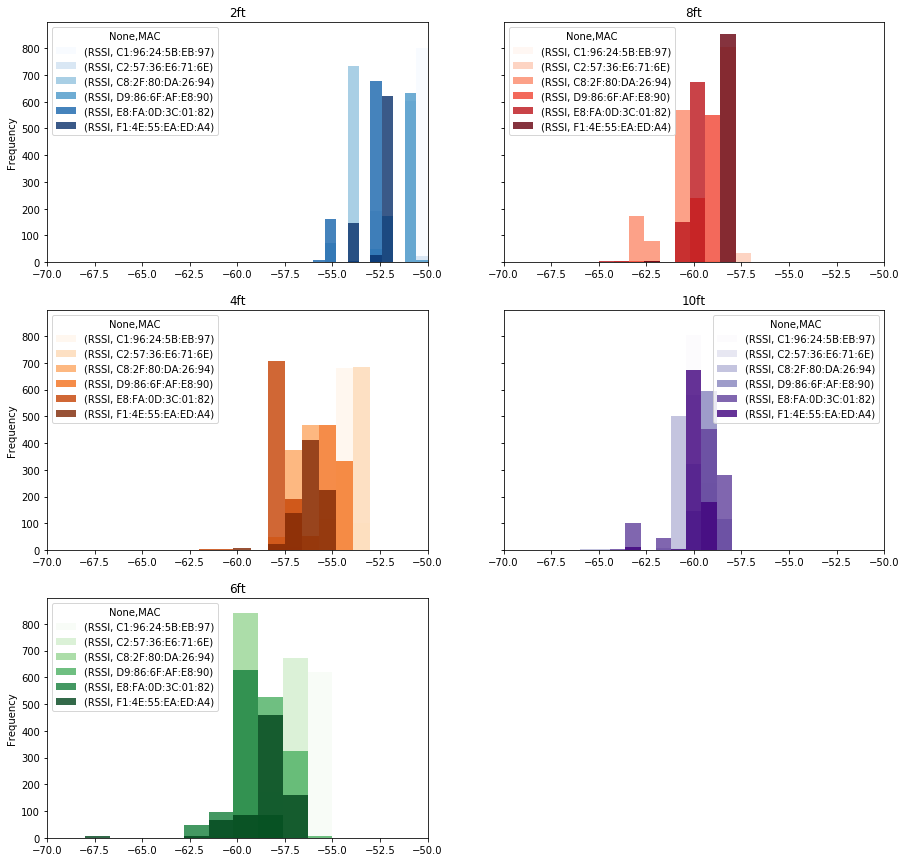

In [12]:
rmx2 = data.loc["regular"].loc[2].groupby("MAC").rolling(5).max().unstack(level="MAC")
rmx4 = data.loc["regular"].loc[4].groupby("MAC").rolling(5).max().unstack(level="MAC")
rmx6 = data.loc["regular"].loc[6].groupby("MAC").rolling(5).max().unstack(level="MAC")
rmx8 = data.loc["regular"].loc[8].groupby("MAC").rolling(5).max().unstack(level="MAC")
rmx10 = data.loc["regular"].loc[10].groupby("MAC").rolling(5).max().unstack(level="MAC")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15), sharey=True)
rmx2.plot(ax=axes[0][0], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Blues", title="2ft")
rmx4.plot(ax=axes[1][0], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Oranges", title="4ft")
rmx6.plot(ax=axes[2][0], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Greens", title="6ft")
rmx8.plot(ax=axes[0][1], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Reds", title="8ft")
rmx10.plot(ax=axes[1][1], kind='hist', bins=10, alpha=.8, xlim=(-70,-50), colormap="Purples", title="10ft")
fig.delaxes(axes[2][1])